In [1]:
%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

In [129]:
# Use full browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline 

paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/MPS1/1bLs736 - 80340.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS2/1kAg181-2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS3/1kvR906 - 3.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS4/1YaA080 - 3.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS5/2bai335 - 6.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS6/2bjs359 - 4.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS7/2dgm988 - 601.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS8/2FfC223 - 2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS9/2uTT322 - 2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS10/2VAp647 - 200.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS11/2viJ294 - 2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS12/2wbs775 - 5.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS13/3BSL889 - 250.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS14/3DJe857 - 252.nii.gz',
         ]

for i in range(len(paths)):
# for i in range(0,1):
    path = paths[i]
    print( "Reading directory:", path)
    file = os.path.split(os.path.split(path)[0])[1]
    img = sitk.Cast(sitk.ReadImage(path), sitk.sitkFloat32)
    size = img.GetSize()
    spacing = img.GetSpacing()
    dir_name = os.path.split(path)[0]
    mps = sitk.ReadImage(dir_name + '/mls.nii.gz')

    img_resampled = resample(img, new_size=[400, 400, 60])
    mps_resampled = resample_mask(mps, new_size=[400, 400, 60])

    print("Spacing: {}".format(img.GetSpacing()),'Origin:{}'.format(img.GetOrigin()))
    display_image(img, window=90, level=40)
    display_image(mps)
    
    
    print("Spacing: {}".format(img_resampled.GetSpacing()))
    display_image(img_resampled, window=90, level=40)
    display_image(mps_resampled)

#     sitk.WriteImage(img_resampled,dir_name + '/' + file+'_Resampled.nii.gz')
#     sitk.WriteImage(mps_resampled,dir_name + '/' + 'mps_Resampled.nii.gz')





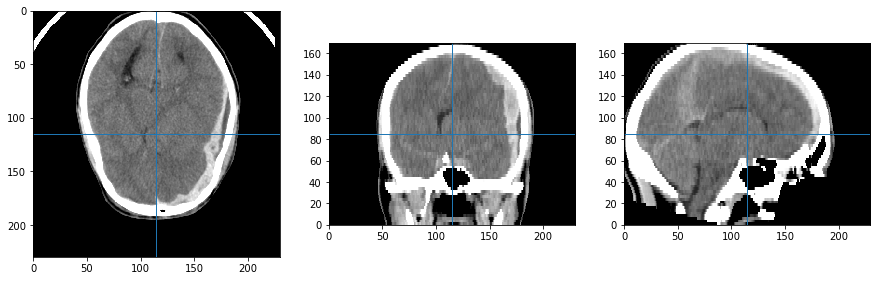

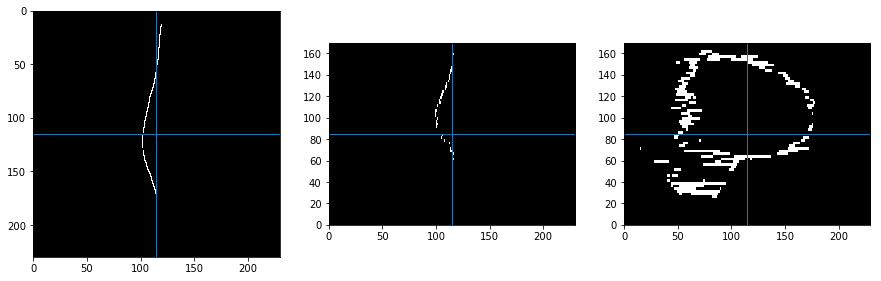

In [131]:
img1 = sitk.Cast(sitk.ReadImage(paths[0]), sitk.sitkFloat32)
mps = sitk.ReadImage(dir_name + '/mls.nii.gz')
display_image(img1, window=90, level=40)
display_image(mps)


In [132]:
dimension = img1.GetDimension()
old_spacing = img1.GetSpacing()
old_size = img1.GetSize()

# reference_direction = np.identity(dimension).flatten()
reference_direction = (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
reference_size = [400,400,60]
reference_spacing = [old_spacing[d] * old_size[d] / reference_size[d] for d in range(3)]
reference_origin = np.zeros(dimension)


In [133]:
reference_image = sitk.Image(reference_size, img1.GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)
reference_center = np.array(
    reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize()) / 2.0))



In [134]:
transform = sitk.AffineTransform(dimension) # use affine transform with 3 dimensions
transform.SetMatrix(img1.GetDirection()) # set the cosine direction matrix
transform.SetTranslation(np.array(img1.GetOrigin()) - reference_origin) # set the translation.
# Modify the transformation to align the centers of the original and reference image instead of their origins.
centering_transform = sitk.TranslationTransform(dimension)
img_center = np.array(img1.TransformContinuousIndexToPhysicalPoint(np.array(img1.GetSize()) / 2.0))
centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
centered_transform = sitk.Transform(transform)
centered_transform.AddTransform(centering_transform)
# Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth
# segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that
# no new labels are introduced.

In [135]:
resampled_img = sitk.Resample(img1, reference_image, centered_transform, sitk.sitkLinear, 0.0)
resampled_mps = sitk.Resample(mps, reference_image, centered_transform, sitk.sitkNearestNeighbor, 0.0)



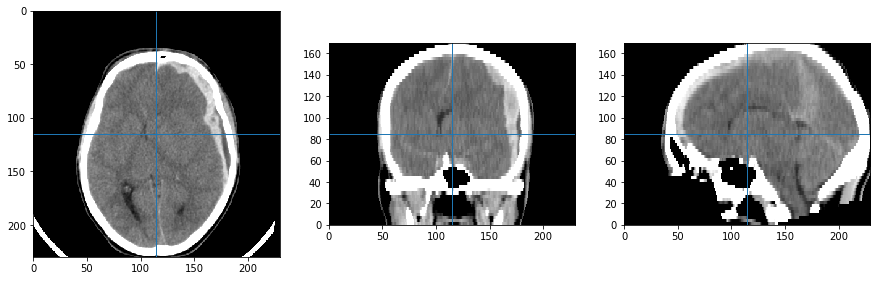

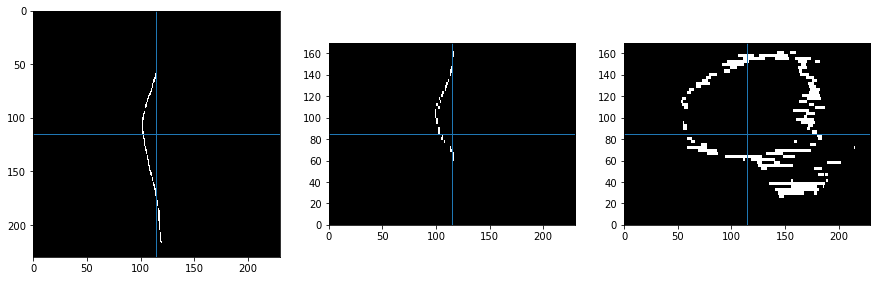

In [136]:
display_image(resampled_img, window=90, level=40)
display_image(resampled_mps)


In [137]:
resampled_img.GetOrigin(),
resampled_img.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
resampled_mps.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))

In [138]:
dir_name = '/Volumes/FAIR/Eric_Midlinedeliniation/MPS1'

In [139]:
sitk.WriteImage(resampled_img, dir_name + '/' + '_Resampled.nii.gz')
sitk.WriteImage(resampled_mps, dir_name + '/' + '_Rwesampled.nii.gz')

In [97]:
img11 = sitk.ReadImage(dir_name + '/' + '_Resampled.nii.gz')

In [100]:
img11.GetDirection()

(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)